In [129]:
import pandas as pd
import seaborn as sns

sns.set() 

import logging
import warnings

# Gensim
import gensim
import gensim.corpora as corpora

# Display setting to show more characters in column
pd.set_option('display.max_columns', 500)

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come', 'com', 'http', 'mail', 'pm', 'image', 'font', 'let', 'br'])

import pickle
import pyLDAvis
import pyLDAvis.gensim_models

### Load data

In [130]:
data_ready = pickle.load( open( "data/clean_words_sample.pickle", "rb" ) )

### LDA

In [131]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]



# print(lda_model.print_topics())


In [132]:
# Build LDA model

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,
    random_state=100,
    update_every=1,
    chunksize=100,
    passes=100,
    alpha="auto",
    iterations=100,
    per_word_topics=True,
)

In [141]:
version="v2"
lda_model_name = f"lda_model_sample_{version}"
pickle.dump(lda_model, open(f"data/{lda_model_name}.pickle", "wb"))

# Topic


In [142]:
data = pickle.load( open( "data/data_sample.pickle", "rb" ) )
lda_model = pickle.load( open( f"data/{lda_model_name}.pickle", "rb" ) )


In [143]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]),
                    ignore_index=True,
                )
            else:
                break
    sent_topics_df.columns = ["Dominant_Topic", "Perc_Contribution", "Topic_Keywords"]

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


In [144]:
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=lda_model, corpus=corpus, texts=data_ready
)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    "Document_No",
    "Dominant_Topic",
    "Topic_Perc_Contrib",
    "Keywords",
    "Text",
]
df_dominant_topic.head(2)


/var/folders/f_/lq61lr8515sdgzbg0slfc_5c0000gn/T/ipykernel_27353/2689881985.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(
/var/folders/f_/lq61lr8515sdgzbg0slfc_5c0000gn/T/ipykernel_27353/2689881985.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.5972,"send, message, original, call, forward, agreem...","[set, interview, cooperation, assistant, vince..."
1,1,1,0.3937,"send, message, original, call, forward, agreem...","[change, broker]"


In [145]:
email_df = pd.read_csv("data/sample.csv")
email_df.head(2)

,id_mail,date,from,to,subject,body,x_origin
0,<13071131.1075863439427.JavaMail.evans@thyme>,2001-08-21 12:17:51-07:00,j.kaminski@enron.com,johnny.palmer@enron.com,RE: Brian Crone,"Johnny\n\nThanks. Please, set up an interview ...",Kaminski-V
1,<17003403.1075841892535.JavaMail.evans@thyme>,2001-02-13 06:18:00-08:00,kate.symes@enron.com,kerri.thompson@enron.com,Re: apb,changed\n\n\n\n\nKerri Thompson@ENRON\n02/13/2...,SYMES-K


In [138]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby("Dominant_Topic")

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat(
        [
            sent_topics_sorteddf_mallet,
            grp.sort_values(["Perc_Contribution"], ascending=False).head(1),
        ],
        axis=0,
    )

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = [
    "Topic_Num",
    "Topic_Perc_Contrib",
    "Keywords",
    "Representative Text",
]

# Show
sent_topics_sorteddf_mallet.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9085,"business, service, report, new, company, produ...","[due, system, error, original, email, open, la..."
1,1,0.9699,"send, message, original, call, forward, agreem...","[paulhasting, new, address, paul_hasting, llp,..."
2,2,0.9893,"deal, gas, day, price, contract, rate, transac...","[hour_hourahead, schedule, require, txt, error..."
3,3,0.9427,"power, energy, company, state, market, price, ...","[appeal, court, decline, order, energy, price,..."
4,4,0.9708,"www, day, free, class, week, time, way, size, ...","[head, receive, report, sign, football, defaul..."


### combine df

In [139]:
email_with_topic = pd.concat([email_df, df_dominant_topic], axis=1)
email_with_topic.to_csv(f"data/email_with_topic_sample_{version}.csv", index=False)

## cloud

IndexError: list index out of range

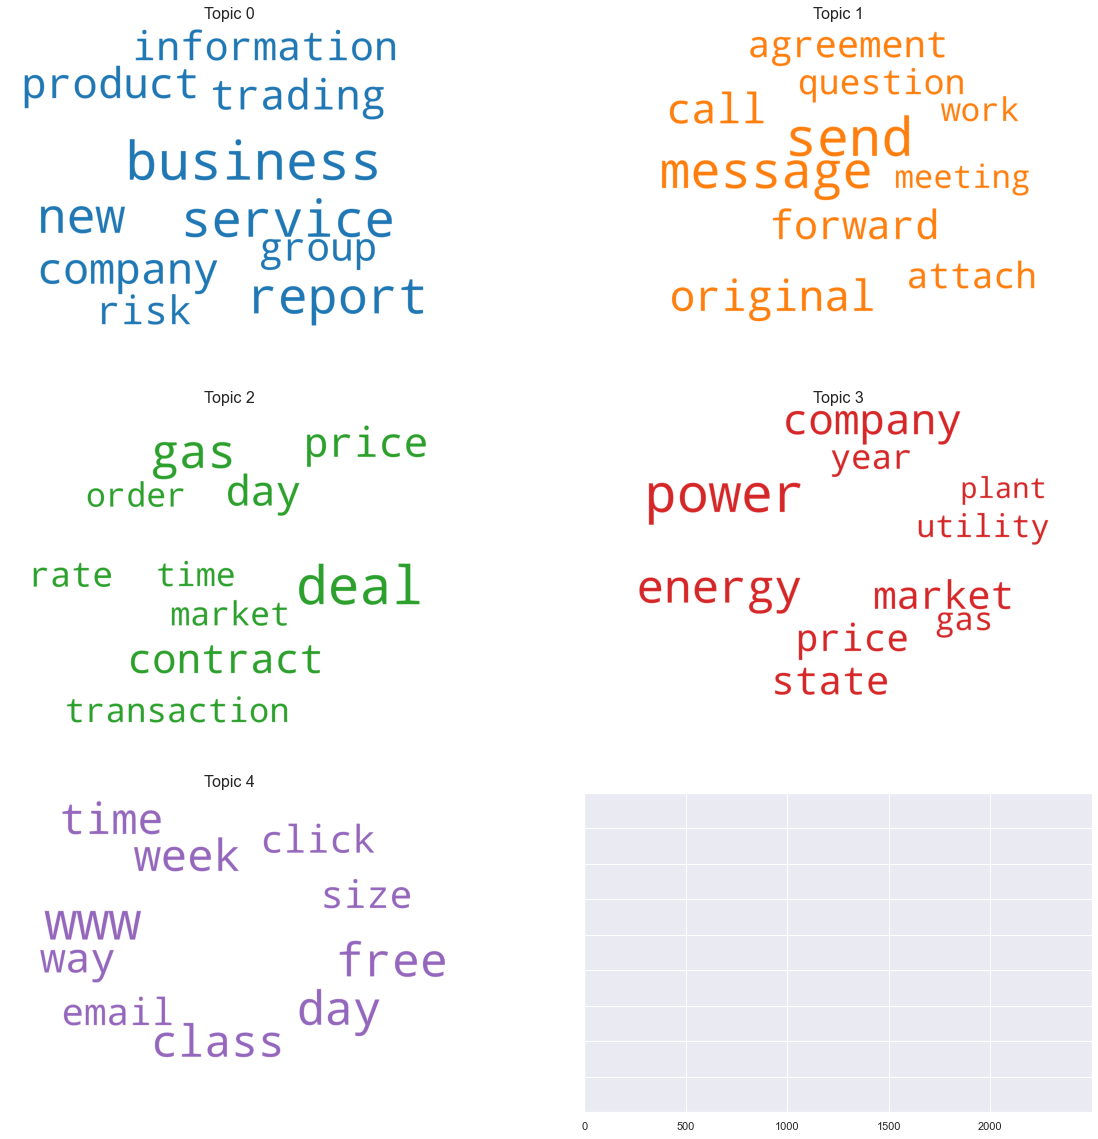

In [146]:


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### VIZ

In [147]:

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(f"lda_model_sample_{version}"))

if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(f"lda_model_sample_{version}") +'.html')
LDAvis_prepared

/Users/hsinhan/PycharmProjects/Enron_Email_Usecase/venv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/hsinhan/PycharmProjects/Enron_Email_Usecase/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/hsinhan/PycharmProjects/Enron_Email_Usecase/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/hsinhan/PycharmProjects/Enron_Email_Usecase/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; se

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.057473 -0.013475       1        1  30.056544
1     -0.062503  0.264584       2        1  25.576318
0      0.119671 -0.222800       3        1  18.522374
4     -0.334426 -0.090573       4        1  13.345375
2      0.219784  0.062264       5        1  12.499389, topic_info=         Term          Freq         Total Category  logprob  loglift
25       send  54874.000000  54874.000000  Default  30.0000  30.0000
17    message  49260.000000  49260.000000  Default  29.0000  29.0000
584     power  60264.000000  60264.000000  Default  28.0000  28.0000
905      deal  31152.000000  31152.000000  Default  27.0000  27.0000
191       gas  41798.000000  41798.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
106      time   9845.686047  51955.900412   Topic5  -4.7190   0.4161
31     change   7242.024788  28390.388220   Topic5  -5.0262   0.7133
486    system   6293.521761  17841.283342   Topic5  -5.1666   1.0375
1214  require   5465.938278  10767.988979   Topic5  -5.3075   1.4014
149   provide   5680.731961  25654.527824   Topic5  -5.2690   0.5719

[332 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1135      3  0.999708      aa
490       1  0.045236  access
490       2  0.075526  access
490       3  0.862344  access
490       5  0.016854  access
...     ...       ...     ...
297       4  0.999524   yahoo
1475      4  0.999474    yard
113       1  0.636338    year
113       3  0.199707    year
113       4  0.163931    year

[523 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 5, 3])

In [148]:
final_df = pd.read_csv("data/email_with_topic_sample_v1.csv")
final_df.shape

(100000, 12)

In [149]:
final_df.head(1)

,id_mail,date,from,to,subject,body,x_origin,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,<26413697.1075860019990.JavaMail.evans@thyme>,2000-08-28 06:45:00-07:00,heather.alon@enron.com,"leslie.hansen@enron.com, mark.taylor@enron.com",Price Limit Orders,"Hi,\n I am working on a postcard for price lim...",Taylor-M,0,2,0.4393,"send, message, forward, original, attach, agre...","['work', 'postcard', 'price', 'limit', 'order'..."
